In [1]:
import glob
import os

import numpy as np
import pandas as pd
import xarray as xr

import dask
# from SALib.analyze import delta

## Preliminaries

In [2]:
# Paths
main_path = "/gpfs/group/kaf26/default/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/"

In [6]:
############
### Dask ###
############
from dask_jobqueue import PBSCluster

cluster = PBSCluster(
    cores=1, resource_spec="pmem=50GB", memory="50GB", worker_extra_args=["#PBS -l feature=rhel7"], walltime="03:00:00"
)

cluster.scale(jobs=20)  # ask for jobs

from dask.distributed import Client

client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.102.10.108:41090,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


In [3]:
# Read all climate drivers
df_climate_drivers = pd.read_csv('../utils/climate_drivers.csv')

## Make some simplifications
# Drop some SSPs
df_climate_drivers_use = df_climate_drivers[~df_climate_drivers.ssp.isin(['historical', 'ssp126'])]

# Drop models not in at least 2 ensembles
models_to_drop = pd.DataFrame(df_climate_drivers_use.groupby(['model', 'ssp']).count().ensemble == 1).query('ensemble == 1').reset_index().model.unique()
df_climate_drivers_use = df_climate_drivers_use[~df_climate_drivers_use.model.isin(models_to_drop)]

In [5]:
def perform_SA(df, metric_type, metrics, aggregator, central_year, window_size, coords, calculate_metrics, calculate_SA, in_path, out_path, out_filename):
    """
    Perform SA on selected metric.
    """

    def read_nc(
        in_path,
        metric_type,
        metrics,
        ensemble,
        model,
        method,
        ssp,
        member,
        central_year,
        window_size,
        coords,
        aggregator,
    ):
        # Add method to ORNL
        if ensemble == "OakRidge":
            member_method = f"{member}_{method}"
        else:
            member_method = member

        # File prefix
        file_prefix = f"{in_path}/{metric_type}/{ensemble}_{model}_{member_method}_{ssp}"

        # Check if all years available
        start_year = int(central_year - window_size / 2)
        end_year = int(central_year + window_size / 2)
        year_range = range(start_year, end_year)
        check = np.sum([os.path.isfile(f"{file_prefix}_{str(year)}.nc") for year in year_range])
        # Loop through all years
        if check == window_size:
            ds_list = []
            for year in year_range:
                ds_tmp = xr.open_dataset(f"{file_prefix}_{str(year)}.nc")
                if coords:
                    if len(coords) == 2:
                        ds_tmp = ds_tmp.sel(lat=coords[0], lon=coords[1], method="nearest")
                    elif len(coords) == 4:
                        ds_tmp = ds_tmp.sel(lat=slice(coords[0],coords[1]), lon=slice(coords[2],coords[3]))
                if metrics:
                    ds_tmp = ds_tmp[metrics]
                ds_list.append(ds_tmp)
            # Aggregate and return
            ds = xr.concat(ds_list, dim="time")
            return aggregator(ds)
        else:
            return False

    # Ensemble lookup
    ensemble_lookup = {
        "NEX-GDDP": "NEX-GDDP",
        "LOCA2": "LOCA2",
        "DBCCA_Daymet": "OakRidge",
        "RegCM_Daymet": "OakRidge",
        "DBCCA_Livneh": "OakRidge",
        "RegCM_Livneh": "OakRidge",
    }
    ####################
    # Calculate metrics
    ####################
    if calculate_metrics:
        ##### Loop through climate drivers
        # need to do this in manner such that we can
        # concat along each dimension sequentially
    
        # Loop through methods
        method_out = []
        for method in df.method.unique():
            df_method = df[df.method == method]
            # Loop through models
            model_out = []
            for model in df_method.model.unique():
                df_model = df_method[df_method.model == model]
                # Loop through SSPs
                ssp_out = []
                for ssp in df_model.ssp.unique():
                    df_ssp = df_model[df_model.ssp == ssp]
                    # Loop through members
                    member_out = []
                    for member in df_ssp.member.unique():
                        # Read file
                        file = read_nc(
                            in_path=in_path,
                            metric_type=metric_type,
                            metrics=metrics,
                            ensemble=ensemble_lookup[method],
                            model=model,
                            method=method,
                            ssp=ssp,
                            member=member,
                            central_year=central_year,
                            coords=coords,
                            window_size=window_size,
                            aggregator=aggregator,
                        )
                        # Append member
                        if file:
                            member_out.append(file)
                    # Concat member
                    if len(member_out) > 0:
                        member_out = xr.concat(member_out, dim="member", fill_value=np.nan)
                        # Append SSP
                        ssp_out.append(member_out)
                # Concat SSP
                if len(ssp_out) > 0:
                    ssp_out = xr.concat(ssp_out, dim="ssp", fill_value=np.nan)
                    # Append model
                    model_out.append(ssp_out)
            # Concat model
            if len(model_out) > 0:
                model_out = xr.concat(model_out, dim="model", fill_value=np.nan)
                # Append method
                method_out.append(model_out)
        # Concat method
        if len(method_out) > 0:
            ds = xr.concat(method_out, dim="method", fill_value=np.nan)
        else:
            return None
        
        # Store intermediate results
        ds.to_netcdf(f"{out_path}/metrics/{out_filename}/{str(central_year)}.nc")
    else:
        try:
            ds = xr.open_dataset(f"{out_path}/metrics/{out_filename}/{str(central_year)}.nc")
        except:
            return None
    
    if calculate_SA:
        #################
        # Calculate SA
        #################
        ## Scenario uncertainty
        # HS09 approach: variance across multi-model means
        U_scen_hs09 = ds.mean(dim=["model", "method", "member"]).var(dim="ssp", ddof=1)
        # BB13 approach: variance across scenarios, averaged over models and ensembles (no weighting)
        U_scen_bb13 = ds.var(dim="ssp", ddof=1).mean(dim=["model", "member", "method"])

        ##  Model uncertainty
        # Variance across models, averaged over scenarios and ensembles
        U_model = ds.mean(dim='member').var(dim="model", ddof=1)
        weights = ds.isel(lat=0, lon=0)[list(ds.data_vars)[0]].mean(dim='member').count(dim="model").rename("weights")
        weights = xr.where(weights <= 1, 0, weights)  # remove combinations where variance was calculated over 1 entry
        U_model_weighted = U_model.weighted(weights).mean(dim=["ssp", "method"])  # weighted average
        U_model_unweighted = U_model.mean(dim=["ssp", "method"])  # simple average

        ## Downscaling uncertainy
        # Variance across ensembles, averaged over models and scenarios
        U_method = ds.var(dim="method", ddof=1)
        weights = ds.isel(lat=0, lon=0)[list(ds.data_vars)[0]].count(dim="method").rename("weights")  # weights
        weights = xr.where(weights <= 1, 0, weights)  # remove combinations where variance was calculated over 1 entry
        U_method_weighted = U_method.weighted(weights).mean(dim=["ssp", "model", "member"])  # weighted average
        U_method_unweighted = U_method.mean(dim=["ssp", "model", "member"])  # simple average

        ## Internal variability
        # Variance across members, averaged over (only LOCA2) models and scenarios
        U_iv = ds.var(dim="member", ddof=1)
        weights = ds.isel(lat=0, lon=0)[list(ds.data_vars)[0]].count(dim="member").rename("weights")  # weights
        weights = xr.where(weights <= 1, 0, weights)  # remove combinations where variance was calculated over 1 entry
        U_iv_weighted = U_iv.weighted(weights).mean(dim=["ssp", "model", "method"])  # weighted average
        U_iv_unweighted = U_iv.mean(dim=["ssp", "model", "method"])  # simple average

        ## Merge and store
        U_scen_hs09 = U_scen_hs09.assign_coords(uncertainty="scenario_hs09")
        U_scen_bb13 = U_scen_bb13.assign_coords(uncertainty="scenario_bb13")
        U_model_weighted = U_model_weighted.assign_coords(uncertainty="model_weighted")
        U_model_unweighted = U_model_unweighted.assign_coords(uncertainty="model_unweighted")
        U_method_weighted = U_method_weighted.assign_coords(uncertainty="method_weighted")
        U_method_unweighted = U_method_unweighted.assign_coords(uncertainty="method_unweighted")
        U_iv_weighted = U_iv_weighted.assign_coords(uncertainty="iv_weighted")
        U_iv_unweighted = U_iv_unweighted.assign_coords(uncertainty="iv_unweighted")

        U_out = xr.concat([U_scen_hs09, U_scen_bb13,
                           U_model_weighted, U_model_unweighted,
                           U_method_weighted, U_method_unweighted,
                           U_iv_weighted, U_iv_unweighted], dim="uncertainty")

        U_out = U_out.assign_coords(time=central_year)

        # Store
        U_out.to_netcdf(f"{out_path}/uc_results/{out_filename}/{str(central_year)}.nc")

In [11]:
%%time

def aggregator(ds):
    # return ds.where(ds.time.dt.month.isin([4,5,6,7,8])).resample(time="1Y").sum().mean(dim="time")
    return ds.mean(dim="time")

out_filename = "tas_prcp_dd_soilM_annual_run10avg"
# metrics = ["edd_29c", "edd_29c_soilMoistFrac_0-10", "prcp", "gdd_10-29c", "soilMoistFrac", "edd_29c_soilMoistFrac_90-100"]

delayed = []
for year in range(2020,2095):
    if not os.path.isfile(f"{main_path}/uc_results/{out_filename}/{str(year)}.nc"):
        delayed.append(dask.delayed(perform_SA)(df=df_climate_drivers_use,
                                                metric_type="tas_prcp_dd_soilM_annual",
                                                metrics=False,
                                                aggregator=aggregator,
                                                central_year=year,
                                                window_size=10,
                                                coords=[33,48,-105,-80],
                                                calculate_metrics = True,
                                                calculate_SA = True,
                                                in_path=f"{main_path}/metrics",
                                                out_path=main_path,
                                                out_filename=out_filename)
                      )
    
_ = dask.compute(*delayed)

CPU times: user 3min 6s, sys: 23.8 s, total: 3min 30s
Wall time: 28min 12s


In [9]:
## Scenario uncertainty
# HS09 approach: variance across multi-model means
U_scen_hs09 = ds.mean(dim=["model", "method", "member"]).var(dim="ssp")
# BB13 approach: variance across scenarios, averaged over models and ensembles (no weighting)
U_scen_bb13 = ds.var(dim="ssp").mean(dim=["model", "member", "method"])

##  Model uncertainty
# Variance across models, averaged over scenarios and ensembles
U_model = ds.mean(dim='member').var(dim="model")
weights = ds.isel(lat=0, lon=0)[list(ds.data_vars)[0]].mean(dim='member').count(dim="model").rename("weights")
weights = xr.where(weights <= 1, 0, weights)  # remove combinations where variance was calculated over 1 entry
U_model_weighted = U_model.weighted(weights).mean(dim=["ssp", "method"])  # weighted average
U_model_unweighted = U_model.mean(dim=["ssp", "method"])  # simple average

## Downscaling uncertainy
# Variance across ensembles, averaged over models and scenarios
U_method = ds.var(dim="method")
weights = ds.isel(lat=0, lon=0)[list(ds.data_vars)[0]].count(dim="method").rename("weights")  # weights
weights = xr.where(weights <= 1, 0, weights)  # remove combinations where variance was calculated over 1 entry
U_method_weighted = U_method.weighted(weights).mean(dim=["ssp", "model", "member"])  # weighted average
U_method_unweighted = U_method.mean(dim=["ssp", "model", "member"])  # simple average

## Internal variability
# Variance across members, averaged over (only LOCA2) models and scenarios
U_iv = ds.var(dim="member")
weights = ds.isel(lat=0, lon=0)[list(ds.data_vars)[0]].count(dim="member").rename("weights")  # weights
weights = xr.where(weights <= 1, 0, weights)  # remove combinations where variance was calculated over 1 entry
U_iv_weighted = U_iv.weighted(weights).mean(dim=["ssp", "model", "method"])  # weighted average
U_iv_unweighted = U_iv.mean(dim=["ssp", "model", "method"])  # simple average

## Merge and return
U_scen_hs09 = U_scen_hs09.assign_coords(uncertainty="scenario_hs09")
U_scen_bb13 = U_scen_bb13.assign_coords(uncertainty="scenario_bb13")
U_model_weighted = U_model_weighted.assign_coords(uncertainty="model_weighted")
U_model_unweighted = U_model_unweighted.assign_coords(uncertainty="model_unweighted")
U_method_weighted = U_method_weighted.assign_coords(uncertainty="method_weighted")
U_method_unweighted = U_method_unweighted.assign_coords(uncertainty="method_unweighted")
U_iv_weighted = U_iv_weighted.assign_coords(uncertainty="iv_weighted")
U_iv_unweighted = U_iv_unweighted.assign_coords(uncertainty="iv_unweighted")

U_out = xr.concat([U_scen_hs09, U_scen_bb13,
                   U_model_weighted, U_model_unweighted,
                   U_method_weighted, U_method_unweighted,
                   U_iv_weighted, U_iv_unweighted], dim="uncertainty")

U_out = U_out.assign_coords(time=year)

In [ ]:
# SA
# SSP uncertainty
ssp_uc = df.groupby(['model', 'method', 'member'])[var_id].var().mean() # BB13
# ssp_uc = df.groupby(['ssp'])[var_id].mean().var()

# Model uncertainty
model_uc = df.groupby(['model','ssp','method'])[var_id].mean().groupby(['ssp','method']).var().mean() # 'forced' response

# Downscaling uncertainty
ds_uc = df.groupby(['model', 'ssp', 'member'])[var_id].var().mean()

# Internal variability
iv_uc = df.groupby(['model', 'method', 'ssp'])[var_id].var().mean()

In [5]:
# Read
df = pd.read_csv("../data/champaign_edd_soilM_all_2050_10avg_gs4-8.csv")

In [6]:
df

,ssp,member,model,method,edd_29c,edd_29c_soilMoistFrac_0-10,ensemble
0,ssp126,r1i1p1f1,ACCESS-CM2,NEX-GDDP,167.161764,57.436327,NEX-GDDP
1,ssp126,r1i1p1f1,ACCESS-ESM1-5,NEX-GDDP,111.108497,25.787698,NEX-GDDP
2,ssp126,r1i1p1f1,BCC-CSM2-MR,NEX-GDDP,86.614981,16.868041,NEX-GDDP
3,ssp126,r1i1p1f1,CMCC-ESM2,NEX-GDDP,56.713626,5.173789,NEX-GDDP
4,ssp126,r1i1p1f1,CanESM5,NEX-GDDP,135.383873,41.009284,NEX-GDDP
...,...,...,...,...,...,...,...
326,ssp585,r5i1p1f1,ACCESS-ESM1-5,LOCA2,160.169323,45.174990,LOCA2
327,ssp585,r5i1p1f1,CanESM5,LOCA2,170.313803,46.737886,LOCA2
328,ssp585,r5i1p1f1,MIROC6,LOCA2,82.423727,9.192094,LOCA2
329,ssp585,r6i1p1f1,CanESM5,LOCA2,205.324377,75.088229,LOCA2


In [77]:
def weighted_average(dataframe, value, weight):
    val = dataframe[value]
    wt = dataframe[weight]
    return (val * wt).sum() / wt.sum()

In [78]:
df_ssp_uc = pd.merge(pd.DataFrame(df.groupby(['model', 'method', 'member'])[var_id].var()),
                     pd.DataFrame(df.groupby(['model', 'method', 'member'])[var_id].count()).rename(columns={'edd_29c_soilMoistFrac_0-10':'weights'}),
                    left_index=True, right_index=True)

weighted_average(df_ssp_uc, 'edd_29c_soilMoistFrac_0-10', 'weights')

96.99533062010592

In [81]:
df_model_uc = pd.merge(pd.DataFrame(df.groupby(['model','ssp','method'])[var_id].mean().groupby(['ssp','method']).var()),
                     pd.DataFrame(df.groupby(['model','ssp','method'])[var_id].mean().groupby(['ssp','method']).count()).rename(columns={'edd_29c_soilMoistFrac_0-10':'weights'}),
                    left_index=True, right_index=True)

weighted_average(df_model_uc, 'edd_29c_soilMoistFrac_0-10', 'weights')

240.805737209383

In [86]:
df.groupby(['model', 'ssp', 'member'])[var_id].count()

model       ssp     member  
ACCESS-CM2  ssp126  r1i1p1f1    1
            ssp245  r1i1p1f1    2
                    r2i1p1f1    1
                    r3i1p1f1    1
            ssp370  r1i1p1f1    2
                               ..
NorESM2-MM  ssp370  r1i1p1f1    2
            ssp585  r1i1p1f1    6
TaiESM1     ssp126  r1i1p1f1    1
            ssp245  r1i1p1f1    2
            ssp370  r1i1p1f1    2
Name: edd_29c_soilMoistFrac_0-10, Length: 252, dtype: int64

In [83]:
df_ds_uc = pd.merge(pd.DataFrame(df.groupby(['model', 'ssp', 'member'])[var_id].var()),
                     pd.DataFrame(df.groupby(['model', 'ssp', 'member'])[var_id].count()).rename(columns={'edd_29c_soilMoistFrac_0-10':'weights'}),
                    left_index=True, right_index=True)

weighted_average(df_ds_uc, 'edd_29c_soilMoistFrac_0-10', 'weights')

26.902007858601028

In [183]:
ssp_uc

160.61812194250717

In [17]:
ssp_uc

28.78987869730504

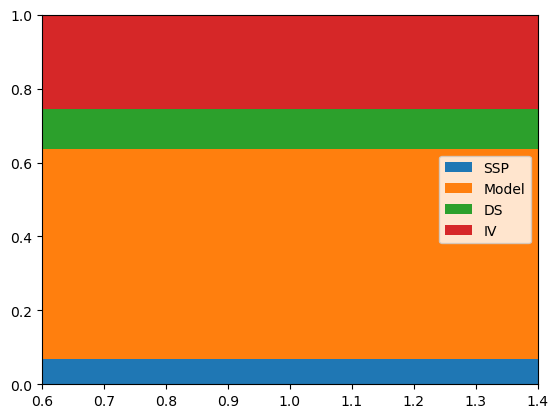

In [31]:
############################################
# 1) SA option 1: using all available data
############################################
var_id = 'edd_29c_soilMoistFrac_0-10' 
# var_id = 'edd_29c'

# SSP uncertainty
ssp_uc = df.groupby(['model', 'method', 'member'])[var_id].var().mean() # BB13
ssp_uc = df.groupby(['ssp'])[var_id].mean().var()

# Model uncertainty
model_uc = df.groupby(['model','ssp','method'])[var_id].mean().groupby(['ssp','method']).var().mean() # 'forced' response

# Downscaling uncertainty
ds_uc = df.groupby(['model', 'ssp', 'member'])[var_id].var().mean()

# Internal variability
iv_uc = df.groupby(['model', 'method', 'ssp'])[var_id].var().mean()

norm = ssp_uc + model_uc + ds_uc + iv_uc

# Plot
uc = {'SSP':ssp_uc/norm, 'Model':model_uc/norm,'DS':ds_uc/norm,'IV':iv_uc/norm}

fig, ax = plt.subplots()
bottom = np.zeros(4)

for label, value in uc.items():
    p = ax.bar([1], value, label=label, bottom=bottom)
    bottom += value
ax.legend()
ax.set_xlim([0.6,1.4])
ax.set_ylim([0,1])
plt.show()

In [10]:
df['subset_index'] = df['model'] + '_' + df['member']

to_drop = df.groupby(['subset_index']).count().reset_index()
to_drop = to_drop[to_drop.edd_29c == 1].model_member_ssp

df[~df.model_member_ssp.isin(to_drop)]

,ssp,member,model,method,edd_29c,edd_29c_soilMoistFrac_0-10,ensemble,model_member_ssp,subset_index
0,ssp126,r1i1p1f1,ACCESS-CM2,NEX-GDDP,167.161764,57.436327,NEX-GDDP,ACCESS-CM2_r1i1p1f1_ssp126,ACCESS-CM2_r1i1p1f1
1,ssp126,r1i1p1f1,ACCESS-ESM1-5,NEX-GDDP,111.108497,25.787698,NEX-GDDP,ACCESS-ESM1-5_r1i1p1f1_ssp126,ACCESS-ESM1-5_r1i1p1f1
2,ssp126,r1i1p1f1,BCC-CSM2-MR,NEX-GDDP,86.614981,16.868041,NEX-GDDP,BCC-CSM2-MR_r1i1p1f1_ssp126,BCC-CSM2-MR_r1i1p1f1
3,ssp126,r1i1p1f1,CMCC-ESM2,NEX-GDDP,56.713626,5.173789,NEX-GDDP,CMCC-ESM2_r1i1p1f1_ssp126,CMCC-ESM2_r1i1p1f1
4,ssp126,r1i1p1f1,CanESM5,NEX-GDDP,135.383873,41.009284,NEX-GDDP,CanESM5_r1i1p1f1_ssp126,CanESM5_r1i1p1f1
...,...,...,...,...,...,...,...,...,...
326,ssp585,r5i1p1f1,ACCESS-ESM1-5,LOCA2,160.169323,45.174990,LOCA2,ACCESS-ESM1-5_r5i1p1f1_ssp585,ACCESS-ESM1-5_r5i1p1f1
327,ssp585,r5i1p1f1,CanESM5,LOCA2,170.313803,46.737886,LOCA2,CanESM5_r5i1p1f1_ssp585,CanESM5_r5i1p1f1
328,ssp585,r5i1p1f1,MIROC6,LOCA2,82.423727,9.192094,LOCA2,MIROC6_r5i1p1f1_ssp585,MIROC6_r5i1p1f1
329,ssp585,r6i1p1f1,CanESM5,LOCA2,205.324377,75.088229,LOCA2,CanESM5_r6i1p1f1_ssp585,CanESM5_r6i1p1f1


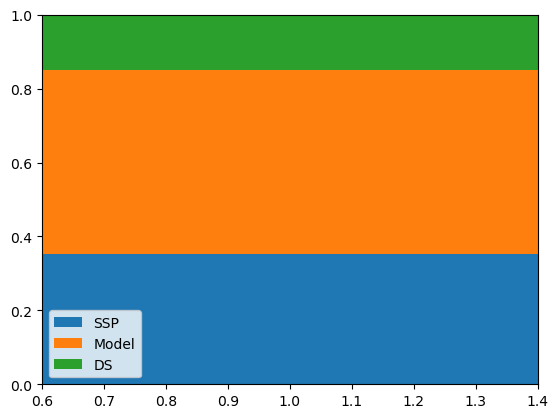

In [7]:
############################################
# 1) SA option 2: using overlap
############################################
# Subset to model in at least 2 ensembles
df['model_member_ssp'] = df['model'] + '_' + df['member'] + '_' + df['ssp']

to_drop = df.groupby(['model_member_ssp']).count().reset_index()
to_drop = to_drop[to_drop.edd_29c == 1].model_member_ssp

df_subset = df[~df.model_member_ssp.isin(to_drop)]

# UC
var_id = 'edd_29c_soilMoistFrac_0-10' 
# var_id = 'edd_29c'

# SSP uncertainty
ssp_uc = df_subset.groupby(['model', 'method'])[var_id].var().mean() # BB13
# ssp_uc = df_subset.groupby(['ssp'])[var_id].mean().var()

# Model uncertainty
model_uc = df_subset.groupby(['ssp','method'])[var_id].var().mean()

# Downscaling uncertainty
ds_uc = df_subset.groupby(['model', 'ssp'])[var_id].var().mean()

norm = ssp_uc + model_uc + ds_uc

# Plot
uc = {'SSP':ssp_uc/norm, 'Model':model_uc/norm,'DS':ds_uc/norm}

fig, ax = plt.subplots()
bottom = np.zeros(3)

for label, value in uc.items():
    p = ax.bar([1], value, label=label, bottom=bottom)
    bottom += value
ax.legend()
ax.set_xlim([0.6,1.4])
ax.set_ylim([0,1])
plt.show()

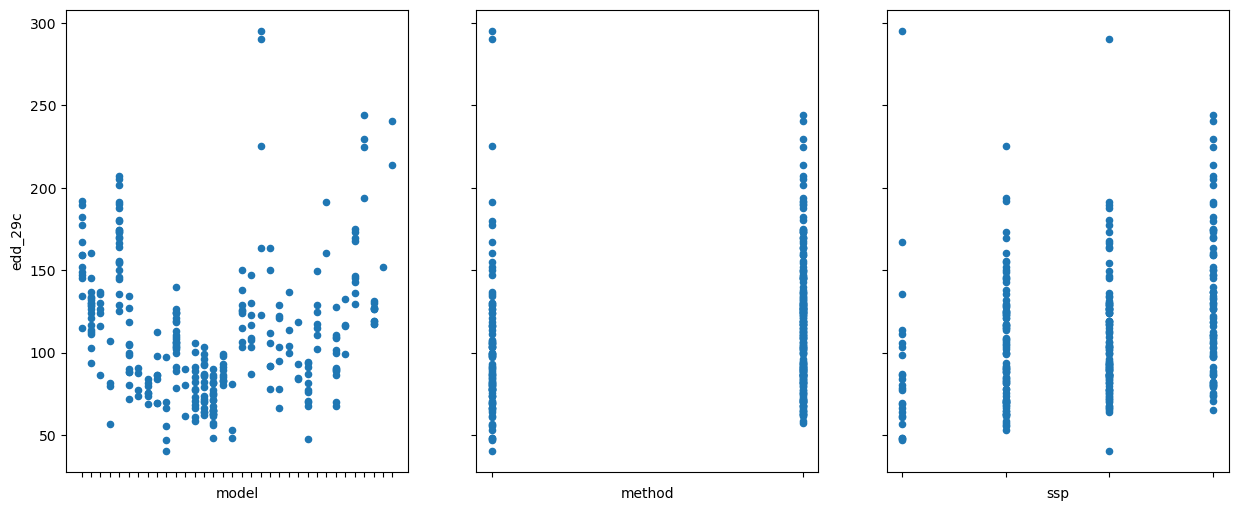

In [130]:
fig, axs = plt.subplots(1,3, figsize=(15,6), sharey=True)
df.plot.scatter(y='edd_29c', x='model', ax=axs[0])
df.plot.scatter(y='edd_29c', x='method', ax=axs[1])
df.plot.scatter(y='edd_29c', x='ssp', ax=axs[2])

for ax in axs:
    # ax.grid()
    ax.set_xticklabels([])
    
plt.show()

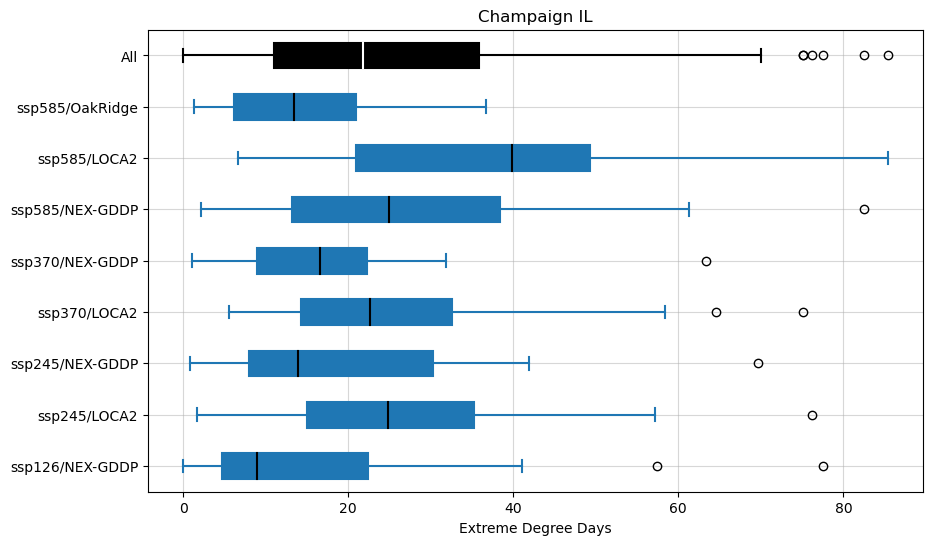

In [12]:
#############
# Make plot
#############
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(alpha=0.5)

lw = 2

colors = {
    "NEX-GDDP": "C0",
    "LOCA2": "C1",
    "DBCCA_Daymet": "C2",
    "RegCM_Daymet": "C3",
    "DBCCA_Livneh": "C4",
    "RegCM_Livneh": "C5",
}

styles = {
    "ssp126": ":",
    "ssp245": "-.",
    "ssp585": "-",
    "ssp370": "--",
}

# which df to use
df_use = df.copy()

idloc = 0
labels=[]
for ids, ssp in enumerate(df_use.ssp.unique()):
    df_ssp = df_use[df_use.ssp == ssp]
    for idm, ensemble in enumerate(df_ssp.ensemble.unique()):
        idloc += 1
        labels.append(f"{ssp}/{ensemble}")
        df_plot = df_ssp[df_ssp.ensemble == ensemble]
        bplot = ax.boxplot(
                positions=[idloc],
                x=df_plot["edd_29c_soilMoistFrac_0-10"],
                vert=False,
                widths=0.5,
                patch_artist=True,
                medianprops=dict(linewidth=lw - 0.5, color="black"),
                boxprops=dict(linewidth=lw - 0.5, color="C0",),
                whiskerprops=dict(linewidth=lw - 0.5, color="C0"),
                capprops=dict(linewidth=lw - 0.5, color="C0"),
                showfliers=True,
            )

        for patch in bplot["boxes"]:
            patch.set_facecolor("C0")

bplot = ax.boxplot(
    positions=[idloc+1],
    x=df_use["edd_29c_soilMoistFrac_0-10"],
    vert=False,
    widths=0.5,
    patch_artist=True,
    medianprops=dict(linewidth=lw - 0.5, color="white"),
    boxprops=dict(linewidth=lw - 0.5, color="black",),
    whiskerprops=dict(linewidth=lw - 0.5, color="black"),
    capprops=dict(linewidth=lw - 0.5, color="black"),
    showfliers=True,
)
for patch in bplot["boxes"]:
            patch.set_facecolor("black")
        
labels.append("All")

ax.set_yticks(ticks=[1]+np.arange(9), labels=labels)
ax.set_xlabel("Extreme Degree Days")
ax.set_title("Champaign IL")

# ssp breaks
# ax.axvline()

# legend
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
# (line1,) = ax.plot([-1, -2, -3], label="NEX-GDDP", color=colors["NEX-GDDP"])
# (line2,) = ax.plot([-1, -2, -3], label="LOCA2", color=colors["LOCA2"])
# (line3,) = ax.plot([-1, -2, -3], label="DBCCA_Daymet", color=colors["DBCCA_Daymet"])
# (line4,) = ax.plot([-1, -2, -3], label="RegCM_Daymet", color=colors["RegCM_Daymet"])
# (line5,) = ax.plot([-1, -2, -3], label="DBCCA_Livneh", color=colors["DBCCA_Livneh"])
# (line6,) = ax.plot([-1, -2, -3], label="RegCM_Livneh", color=colors["RegCM_Livneh"])
# ax.legend(
#     handles=[line1, line2, line3, line4, line5, line6],
#     ncol=2,
#     fontsize=12,
#     columnspacing=0.6,
#     handletextpad=0.5,
#     handlelength=1,
# )

plt.show()

### OLD

In [7]:
from SALib.util import read_param_file

# Read the parameter range file and generate samples
# Since this is "given data", the bounds in the parameter file will not be used
# but the columns are still expected
problem = read_param_file("../data/Ishigami.txt")
X = np.loadtxt("../data/model_input.txt")
Y = np.loadtxt("../data/model_output.txt")

In [74]:
# Perform the sensitivity analysis using the model output
# Specify which column of the output file to analyze (zero-indexed)
# Returns a dictionary with keys 'delta', 'delta_conf', 'S1', 'S1_conf'
Si = delta.analyze(problem, X, Y, num_resamples=10, conf_level=0.95, print_to_console=True)

       delta  delta_conf        S1   S1_conf
x1  0.313063    0.023111  0.183910  0.061531
x2  0.154828    0.021756  0.092322  0.034706
x3  0.208364    0.043316  0.012630  0.042593


In [75]:
################################

In [96]:
# Champaign example
df = pd.read_csv("../data/champaign_all_tasmax_soilM.csv")

In [98]:
# Tread model & member as one
df["model-member"] = df["model"] + "_" + df["member"]

In [101]:
df_days = (
    df.groupby(["year", "method", "model-member", "ssp"])
    .apply(lambda x: ((x["soilMoistFrac"] <= 0.2) & (x["tasmax"] >= 29)).sum())
    .reset_index(name="days")
)

In [104]:
X, Y = df_days[["ssp", "model-member", "method"]].to_numpy(), df_days["days"].to_numpy()

In [105]:
X

array([['ssp585', 'ACCESS-CM2_r1i1p1f1', 'DBCCA_Daymet'],
       ['ssp585', 'BCC-CSM2-MR_r1i1p1f1', 'DBCCA_Daymet'],
       ['ssp585', 'CNRM-ESM2-1_r1i1p1f2', 'DBCCA_Daymet'],
       ...,
       ['ssp585', 'MPI-ESM1-2-HR_r1i1p1f1', 'RegCM_Livneh'],
       ['ssp585', 'MRI-ESM2-0_r1i1p1f1', 'RegCM_Livneh'],
       ['ssp585', 'NorESM2-MM_r1i1p1f1', 'RegCM_Livneh']], dtype=object)

In [24]:
# how many total outputs
len(df.query("time == '2020-04-01'"))

278

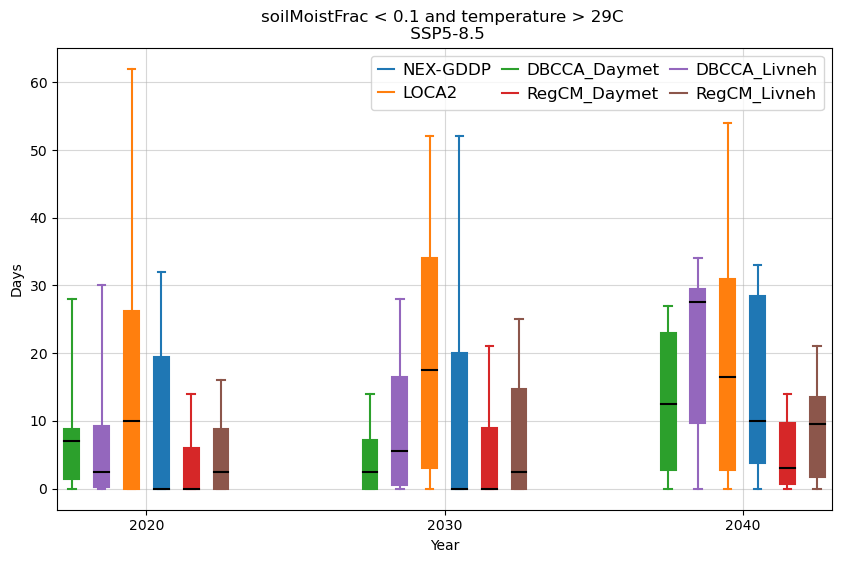

In [25]:
# Calculate metric
t_thresh = 29
soil_thresh = 0.1

df_days = (
    df.groupby(["year", "method", "model-member", "ssp"])
    .apply(lambda x: ((x["soilMoistFrac"] <= soil_thresh) & (x["tasmax"] >= t_thresh)).sum())
    .reset_index(name="days")
)

#############
# Make plot
#############
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(alpha=0.5)

lw = 2

colors = {
    "NEX-GDDP": "C0",
    "LOCA2": "C1",
    "DBCCA_Daymet": "C2",
    "RegCM_Daymet": "C3",
    "DBCCA_Livneh": "C4",
    "RegCM_Livneh": "C5",
}

for year in np.arange(2020, 2041, 10):
    df_year = df_days[df_days.year == year]
    for ssp in ["ssp585"]:
        df_year_ssp = df_year[df_year.ssp == ssp]
        for idm, method in enumerate(df_year_ssp.method.unique()):
            df_plot = df_year_ssp[df_year_ssp.method == method]
            bplot = ax.boxplot(
                positions=[year - 2.5 + idm],
                x=df_plot["days"],
                vert=True,
                widths=0.5,
                patch_artist=True,
                medianprops=dict(linewidth=lw - 0.5, color="black"),
                boxprops=dict(linewidth=lw - 0.5, color=colors[method]),
                whiskerprops=dict(linewidth=lw - 0.5, color=colors[method]),
                capprops=dict(linewidth=lw - 0.5, color=colors[method]),
                whis=(0, 100),
                showfliers=False,
            )

            for patch in bplot["boxes"]:
                patch.set_facecolor(colors[method])

ax.set_xticks([2020, 2030, 2040], labels=["2020", "2030", "2040"])
ax.set_title("soilMoistFrac < 0.1 and temperature > 29C \n SSP5-8.5")
ax.set_xlabel("Year")
ax.set_ylabel("Days")

# legend
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
(line1,) = ax.plot([1, 2, 3], label="NEX-GDDP", color=colors["NEX-GDDP"])
(line2,) = ax.plot([1, 2, 3], label="LOCA2", color=colors["LOCA2"])
(line3,) = ax.plot([1, 2, 3], label="DBCCA_Daymet", color=colors["DBCCA_Daymet"])
(line4,) = ax.plot([1, 2, 3], label="RegCM_Daymet", color=colors["RegCM_Daymet"])
(line5,) = ax.plot([1, 2, 3], label="DBCCA_Livneh", color=colors["DBCCA_Livneh"])
(line6,) = ax.plot([1, 2, 3], label="RegCM_Livneh", color=colors["RegCM_Livneh"])
ax.legend(
    handles=[line1, line2, line3, line4, line5, line6],
    ncol=3,
    fontsize=12,
    loc="upper right",
    columnspacing=0.6,
    handletextpad=0.5,
    handlelength=1,
)

plt.show()

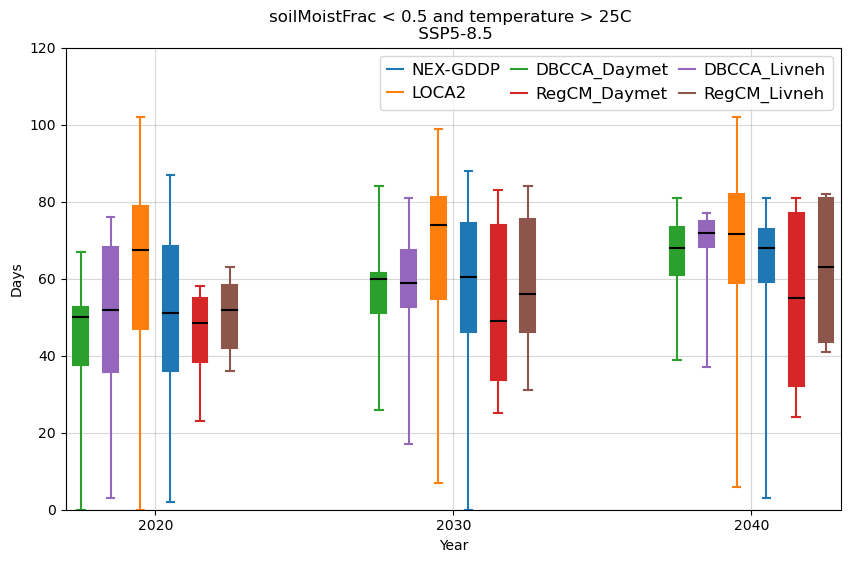

In [26]:
# Calculate metric
t_thresh = 25
soil_thresh = 0.5

df_days = (
    df.groupby(["year", "method", "model-member", "ssp"])
    .apply(lambda x: ((x["soilMoistFrac"] <= soil_thresh) & (x["tasmax"] >= t_thresh)).sum())
    .reset_index(name="days")
)

#############
# Make plot
#############
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(alpha=0.5)

lw = 2

colors = {
    "NEX-GDDP": "C0",
    "LOCA2": "C1",
    "DBCCA_Daymet": "C2",
    "RegCM_Daymet": "C3",
    "DBCCA_Livneh": "C4",
    "RegCM_Livneh": "C5",
}

for year in np.arange(2020, 2041, 10):
    df_year = df_days[df_days.year == year]
    for ssp in ["ssp585"]:
        df_year_ssp = df_year[df_year.ssp == ssp]
        for idm, method in enumerate(df_year_ssp.method.unique()):
            df_plot = df_year_ssp[df_year_ssp.method == method]
            bplot = ax.boxplot(
                positions=[year - 2.5 + idm],
                x=df_plot["days"],
                vert=True,
                widths=0.5,
                patch_artist=True,
                medianprops=dict(linewidth=lw - 0.5, color="black"),
                boxprops=dict(linewidth=lw - 0.5, color=colors[method]),
                whiskerprops=dict(linewidth=lw - 0.5, color=colors[method]),
                capprops=dict(linewidth=lw - 0.5, color=colors[method]),
                whis=(0, 100),
                showfliers=False,
            )

            for patch in bplot["boxes"]:
                patch.set_facecolor(colors[method])

ax.set_xticks([2020, 2030, 2040], labels=["2020", "2030", "2040"])
ax.set_title("soilMoistFrac < 0.5 and temperature > 25C \n SSP5-8.5")
ax.set_xlabel("Year")
ax.set_ylabel("Days")

# legend
ax.set_xlim(ax.get_xlim())
ax.set_ylim([0, 120])
(line1,) = ax.plot([1, 2, 3], label="NEX-GDDP", color=colors["NEX-GDDP"])
(line2,) = ax.plot([1, 2, 3], label="LOCA2", color=colors["LOCA2"])
(line3,) = ax.plot([1, 2, 3], label="DBCCA_Daymet", color=colors["DBCCA_Daymet"])
(line4,) = ax.plot([1, 2, 3], label="RegCM_Daymet", color=colors["RegCM_Daymet"])
(line5,) = ax.plot([1, 2, 3], label="DBCCA_Livneh", color=colors["DBCCA_Livneh"])
(line6,) = ax.plot([1, 2, 3], label="RegCM_Livneh", color=colors["RegCM_Livneh"])
ax.legend(
    handles=[line1, line2, line3, line4, line5, line6],
    ncol=3,
    fontsize=12,
    loc="upper right",
    columnspacing=0.6,
    handletextpad=0.5,
    handlelength=1,
)

plt.show()

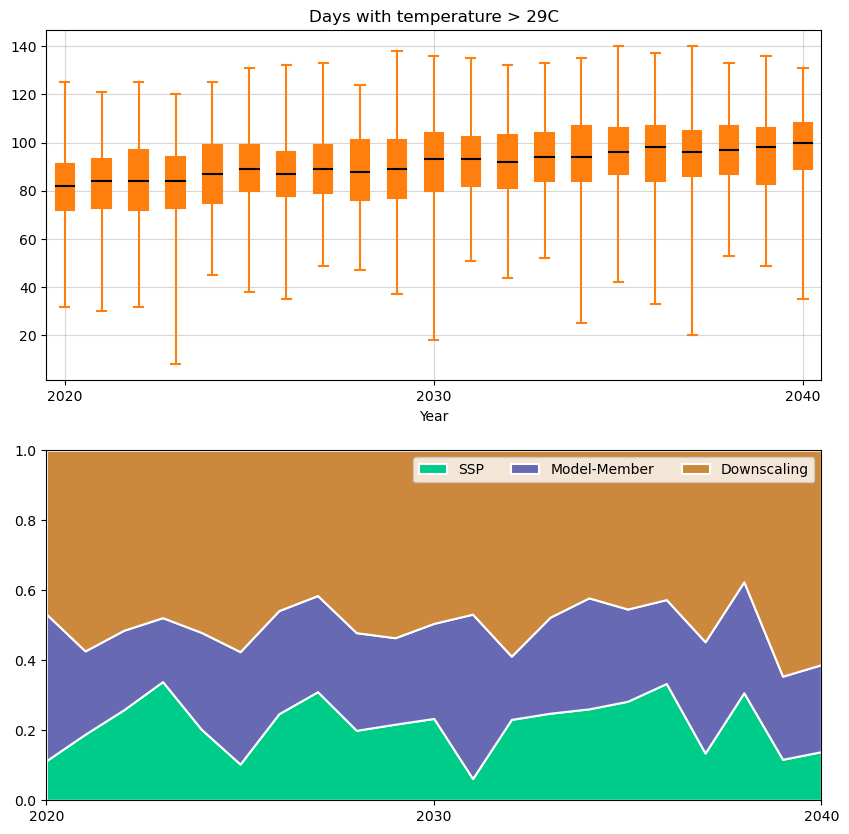

In [28]:
# Calculate metric
t_thresh = 29
soil_thresh = 0.1

df_days = (
    df.groupby(["year", "method", "model-member", "ssp"])
    .apply(lambda x: ((x["tasmax"] >= t_thresh)).sum())
    .reset_index(name="days")
)

#############
# Make plot
#############
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Timeseries
ax = axs[0]
ax.grid(alpha=0.5)

lw = 2
color = "C1"

for year in df_days.year.unique():
    df_year = df_days[df_days.year == year]
    bplot = ax.boxplot(
        positions=[year],
        x=df_year["days"],
        vert=True,
        widths=0.5,
        patch_artist=True,
        medianprops=dict(linewidth=lw - 0.5, color="black"),
        boxprops=dict(linewidth=lw - 0.5, color=color),
        whiskerprops=dict(linewidth=lw - 0.5, color=color),
        capprops=dict(linewidth=lw - 0.5, color=color),
        whis=(0, 100),
        showfliers=False,
    )

    for patch in bplot["boxes"]:
        patch.set_facecolor(color)

ax.set_xticks([2020, 2030, 2040], labels=["2020", "2030", "2040"])

# for method in df_days.method.unique():
#     df_method = df_days[df_days.method == method]
#     for model in df_method.model.unique():
#         df_model = df_method[df_method.model == model]
#         for ssp in df_model.ssp.unique():
#             df_tmp = df_model[df_model.ssp == ssp].sort_values(by="year")
#             ax.plot(df_tmp["year"], df_tmp["days"], color="silver")

ax.set_title("Days with temperature > 29C")
ax.set_xlabel("Year")

# SA
ax = axs[1]

# Analyze annual basis
problem = {
    "names": ["ssp", "model-member", "ensemble"],
    "bounds": [[0, 0], [0, 0], [0, 0]],
    "num_vars": 3,
    "groups": None,
    "dists": None,
}

Si_out = []

for year in df_days.year.unique():
    df_year = df_days[df_days.year == year]
    X, Y = df_year[["ssp", "model-member", "method"]].to_numpy(), df_year["days"].to_numpy()

    Si = delta.analyze(problem, X, Y, num_resamples=10, conf_level=0.95, print_to_console=False)

    Si_out.append(Si["delta"] / np.sum(Si["delta"]))

# Construct plotting dict
uncert_dict = {
    "SSP": np.array([x[0] for x in Si_out]),
    "Model-Member": np.array([x[1] for x in Si_out]),
    "Downscaling": np.array([x[2] for x in Si_out]),
}

ax.stackplot(
    np.arange(2020, 2041),
    uncert_dict.values(),
    labels=uncert_dict.keys(),
    alpha=1,
    colors=["#00CC89", "#6869B3", "#CC883C"],  # , "#FFFF99"],
    edgecolor="white",
    lw=1.5,
)

ax.set_ylim([0, 1])
ax.set_xlim([2020, 2040])
ax.set_xticks([2020, 2030, 2040], labels=["2020", "2030", "2040"])
ax.legend(ncols=4)

plt.show()

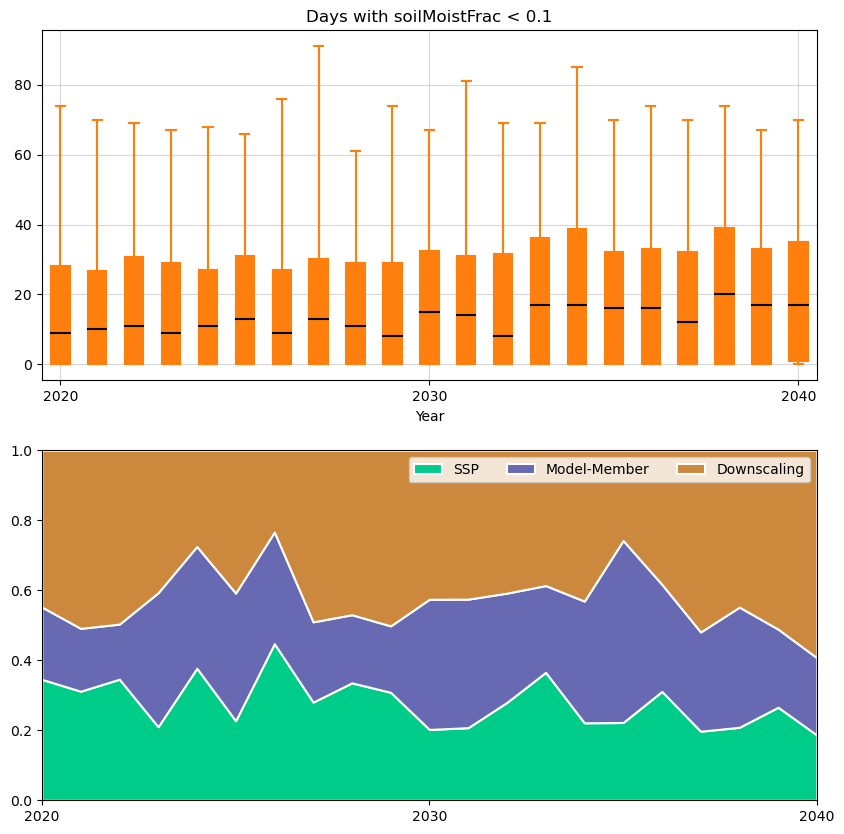

In [30]:
# Calculate metric
t_thresh = 29
soil_thresh = 0.1

df_days = (
    df.groupby(["year", "method", "model-member", "ssp"])
    .apply(lambda x: ((x["soilMoistFrac"] <= soil_thresh)).sum())
    .reset_index(name="days")
)

#############
# Make plot
#############
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Timeseries
ax = axs[0]
ax.grid(alpha=0.5)

lw = 2
color = "C1"

for year in df_days.year.unique():
    df_year = df_days[df_days.year == year]
    bplot = ax.boxplot(
        positions=[year],
        x=df_year["days"],
        vert=True,
        widths=0.5,
        patch_artist=True,
        medianprops=dict(linewidth=lw - 0.5, color="black"),
        boxprops=dict(linewidth=lw - 0.5, color=color),
        whiskerprops=dict(linewidth=lw - 0.5, color=color),
        capprops=dict(linewidth=lw - 0.5, color=color),
        whis=(0, 100),
        showfliers=False,
    )

    for patch in bplot["boxes"]:
        patch.set_facecolor(color)

ax.set_xticks([2020, 2030, 2040], labels=["2020", "2030", "2040"])

# for method in df_days.method.unique():
#     df_method = df_days[df_days.method == method]
#     for model in df_method.model.unique():
#         df_model = df_method[df_method.model == model]
#         for ssp in df_model.ssp.unique():
#             df_tmp = df_model[df_model.ssp == ssp].sort_values(by="year")
#             ax.plot(df_tmp["year"], df_tmp["days"], color="silver")

ax.set_title("Days with soilMoistFrac < 0.1")
ax.set_xlabel("Year")

# SA
ax = axs[1]

# Analyze annual basis
problem = {
    "names": ["ssp", "model-member", "ensemble"],
    "bounds": [[0, 0], [0, 0], [0, 0]],
    "num_vars": 3,
    "groups": None,
    "dists": None,
}

Si_out = []

for year in df_days.year.unique():
    df_year = df_days[df_days.year == year]
    X, Y = df_year[["ssp", "model-member", "method"]].to_numpy(), df_year["days"].to_numpy()

    Si = delta.analyze(problem, X, Y, num_resamples=10, conf_level=0.95, print_to_console=False)

    Si_out.append(Si["delta"] / np.sum(Si["delta"]))

# Construct plotting dict
uncert_dict = {
    "SSP": np.array([x[0] for x in Si_out]),
    "Model-Member": np.array([x[1] for x in Si_out]),
    "Downscaling": np.array([x[2] for x in Si_out]),
}

ax.stackplot(
    np.arange(2020, 2041),
    uncert_dict.values(),
    labels=uncert_dict.keys(),
    alpha=1,
    colors=["#00CC89", "#6869B3", "#CC883C"],  # , "#FFFF99"],
    edgecolor="white",
    lw=1.5,
)

ax.set_ylim([0, 1])
ax.set_xlim([2020, 2040])
ax.set_xticks([2020, 2030, 2040], labels=["2020", "2030", "2040"])
ax.legend(ncols=4)

plt.show()

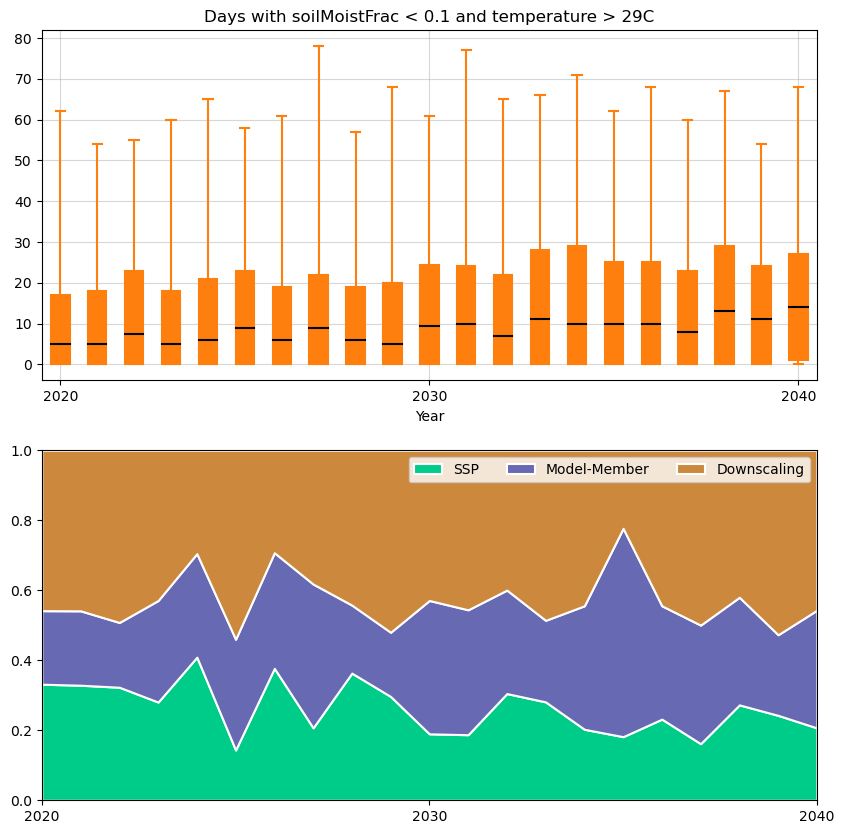

In [27]:
# Calculate metric
t_thresh = 29
soil_thresh = 0.1

df_days = (
    df.groupby(["year", "method", "model-member", "ssp"])
    .apply(lambda x: ((x["soilMoistFrac"] <= soil_thresh) & (x["tasmax"] >= t_thresh)).sum())
    .reset_index(name="days")
)

#############
# Make plot
#############
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Timeseries
ax = axs[0]
ax.grid(alpha=0.5)

lw = 2
color = "C1"

for year in df_days.year.unique():
    df_year = df_days[df_days.year == year]
    bplot = ax.boxplot(
        positions=[year],
        x=df_year["days"],
        vert=True,
        widths=0.5,
        patch_artist=True,
        medianprops=dict(linewidth=lw - 0.5, color="black"),
        boxprops=dict(linewidth=lw - 0.5, color=color),
        whiskerprops=dict(linewidth=lw - 0.5, color=color),
        capprops=dict(linewidth=lw - 0.5, color=color),
        whis=(0, 100),
        showfliers=False,
    )

    for patch in bplot["boxes"]:
        patch.set_facecolor(color)

ax.set_xticks([2020, 2030, 2040], labels=["2020", "2030", "2040"])

# for method in df_days.method.unique():
#     df_method = df_days[df_days.method == method]
#     for model in df_method.model.unique():
#         df_model = df_method[df_method.model == model]
#         for ssp in df_model.ssp.unique():
#             df_tmp = df_model[df_model.ssp == ssp].sort_values(by="year")
#             ax.plot(df_tmp["year"], df_tmp["days"], color="silver")

ax.set_title("Days with soilMoistFrac < 0.1 and temperature > 29C")
ax.set_xlabel("Year")

# SA
ax = axs[1]

# Analyze annual basis
problem = {
    "names": ["ssp", "model-member", "ensemble"],
    "bounds": [[0, 0], [0, 0], [0, 0]],
    "num_vars": 3,
    "groups": None,
    "dists": None,
}

Si_out = []

for year in df_days.year.unique():
    df_year = df_days[df_days.year == year]
    X, Y = df_year[["ssp", "model-member", "method"]].to_numpy(), df_year["days"].to_numpy()

    Si = delta.analyze(problem, X, Y, num_resamples=10, conf_level=0.95, print_to_console=False)

    Si_out.append(Si["delta"] / np.sum(Si["delta"]))

# Construct plotting dict
uncert_dict = {
    "SSP": np.array([x[0] for x in Si_out]),
    "Model-Member": np.array([x[1] for x in Si_out]),
    "Downscaling": np.array([x[2] for x in Si_out]),
}

ax.stackplot(
    np.arange(2020, 2041),
    uncert_dict.values(),
    labels=uncert_dict.keys(),
    alpha=1,
    colors=["#00CC89", "#6869B3", "#CC883C"],  # , "#FFFF99"],
    edgecolor="white",
    lw=1.5,
)

ax.set_ylim([0, 1])
ax.set_xlim([2020, 2040])
ax.set_xticks([2020, 2030, 2040], labels=["2020", "2030", "2040"])
ax.legend(ncols=4)

plt.show()

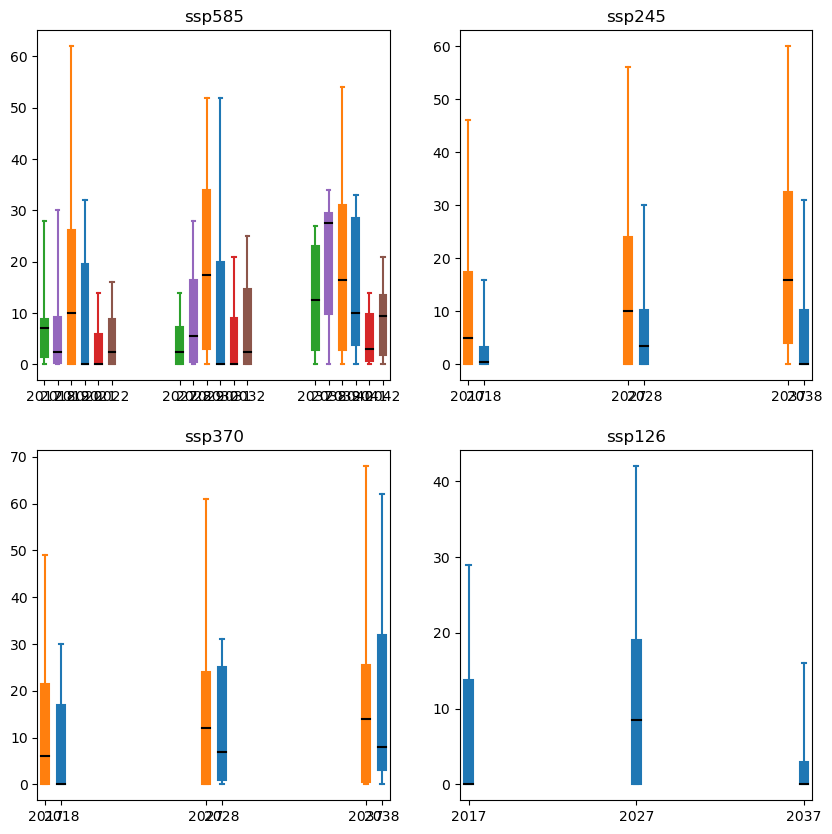

In [165]:
# Calculate metric
t_thresh = 29
soil_thresh = 0.1

df_days = (
    df.groupby(["year", "method", "model", "ssp", "member"])
    .apply(lambda x: ((x["soilMoistFrac"] <= soil_thresh) & (x["tasmax"] >= t_thresh)).sum())
    .reset_index(name="days")
)

#############
# Make plot
#############
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

# Timeseries
ax.grid(alpha=0.5)

lw = 2
colors = {
    "NEX-GDDP": "C0",
    "LOCA2": "C1",
    "DBCCA_Daymet": "C2",
    "RegCM_Daymet": "C3",
    "DBCCA_Livneh": "C4",
    "RegCM_Livneh": "C5",
}

for year in np.arange(2020, 2041, 10):
    df_year = df_days[df_days.year == year]
    for ids, ssp in enumerate(df_year.ssp.unique()):
        axs[ids].set_title(ssp)
        df_year_ssp = df_year[df_year.ssp == ssp]
        for idm, method in enumerate(df_year_ssp.method.unique()):
            df_plot = df_year_ssp[df_year_ssp.method == method]
            bplot = axs[ids].boxplot(
                positions=[year - 3 + idm],
                x=df_plot["days"],
                vert=True,
                widths=0.5,
                patch_artist=True,
                medianprops=dict(linewidth=lw - 0.5, color="black"),
                boxprops=dict(linewidth=lw - 0.5, color=colors[method]),
                whiskerprops=dict(linewidth=lw - 0.5, color=colors[method]),
                capprops=dict(linewidth=lw - 0.5, color=colors[method]),
                whis=(0, 100),
                showfliers=False,
            )

            for patch in bplot["boxes"]:
                patch.set_facecolor(colors[method])

# ax.set_xticks([2020, 2030, 2040], labels=["2020", "2030", "2040"])

ax.set_title("Days with soilMoistFrac < 0.1 and temperature > 29C")
ax.set_xlabel("Year")

plt.show()

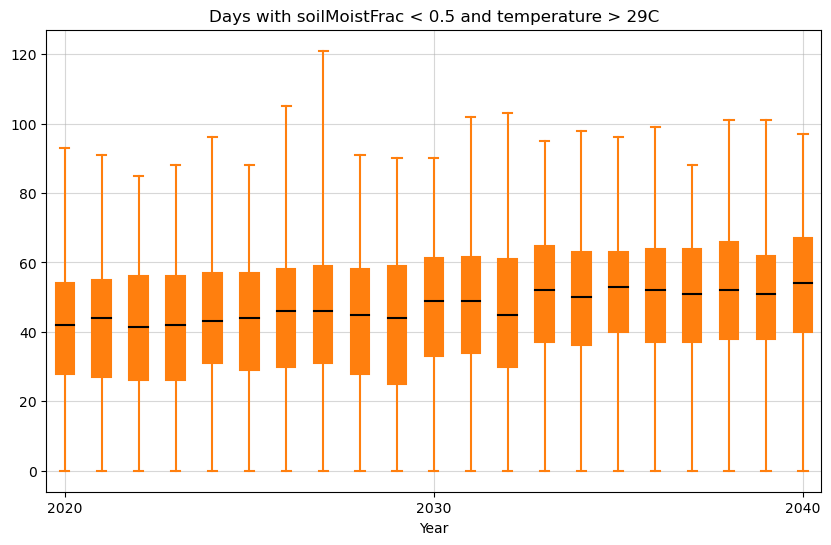

In [86]:
# Calculate metric
t_thresh = 29
soil_thresh = 0.5

df_days = (
    df.groupby(["year", "method", "model", "ssp", "member"])
    .apply(lambda x: ((x["soilMoistFrac"] <= soil_thresh) & (x["tasmax"] >= t_thresh)).sum())
    .reset_index(name="days")
)

# Make plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("")
ax.grid(alpha=0.5)

lw = 2
color = "C1"

for year in df_days.year.unique():
    df_year = df_days[df_days.year == year]
    bplot = ax.boxplot(
        positions=[year],
        x=df_year["days"],
        vert=True,
        widths=0.5,
        patch_artist=True,
        medianprops=dict(linewidth=lw - 0.5, color="black"),
        boxprops=dict(linewidth=lw - 0.5, color=color),
        whiskerprops=dict(linewidth=lw - 0.5, color=color),
        capprops=dict(linewidth=lw - 0.5, color=color),
        whis=(0, 100),
        showfliers=False,
    )

    for patch in bplot["boxes"]:
        patch.set_facecolor(color)

ax.set_xticks([2020, 2030, 2040], labels=["2020", "2030", "2040"])

# for method in df_days.method.unique():
#     df_method = df_days[df_days.method == method]
#     for model in df_method.model.unique():
#         df_model = df_method[df_method.model == model]
#         for ssp in df_model.ssp.unique():
#             df_tmp = df_model[df_model.ssp == ssp].sort_values(by="year")
#             ax.plot(df_tmp["year"], df_tmp["days"], color="silver")

ax.set_title("Days with soilMoistFrac < 0.5 and temperature > 29C")
ax.set_xlabel("Year")
plt.show()

In [14]:
df["model-member"] = df["model"] + "_" + df["member"]

In [20]:
# Calculate metric
df_days = (
    df.groupby(["year", "method", "model-member", "ssp"])
    .apply(lambda x: ((x["soilMoistFrac"] <= 0.1) & (x["tasmax"] >= 29.0)).sum())
    .reset_index(name="days")
    .groupby(["method", "model-member", "ssp"])
    .max()
    .reset_index()
)

In [21]:
X, Y = df_days[["method", "model-member", "ssp"]].to_numpy(), df_days["days"].to_numpy()

In [22]:
# Analyze
problem = {
    "names": ["method", "model-member", "ssp"],
    "bounds": [[0, 0], [0, 0], [0, 0]],
    "num_vars": 3,
    "groups": None,
    "dists": None,
}

Si = delta.analyze(problem, X, Y, num_resamples=10, conf_level=0.95, print_to_console=True)

                 delta  delta_conf        S1   S1_conf
method        0.254845    0.037107  0.215739  0.072727
model-member  0.196409    0.052246  0.236410  0.036980
ssp           0.114754    0.030929  0.026615  0.041027


In [26]:
df_days.groupby("method")["days"].mean().var() / df_days["days"].var()

0.19680783257022674

In [27]:
df_days.groupby("model")["days"].mean().var() / df_days["days"].var()

0.8654698315772877

In [28]:
df_days.groupby("ssp")["days"].mean().var() / df_days["days"].var()

0.17993442879211677

In [111]:
# Calculate metric
df_days = (
    df.groupby(["year", "method", "model"])
    .apply(lambda x: ((x["soilMoistFrac"] <= 0.1) & (x["tasmax"] >= 29.0)).sum())
    .reset_index(name="days")
)

In [112]:
problem = {"num_vars": 2, "names": ["method", "model"], "bounds": [[0, 0], [0, 0]]}

df_out = pd.DataFrame(columns=["method", "model", "year"])

for year in df_days.year.unique():
    # Select year
    df_tmp = df_days[df_days.year == year].copy()
    # Get outputs
    Y = df_tmp["days"].to_numpy()
    X = df_tmp[["method", "model"]].to_numpy()
    # Analyze
    delta_df = (
        delta.analyze(problem, X, Y, num_resamples=10, conf_level=0.95, print_to_console=False).to_df()[["delta"]].T
    )
    delta_df["year"] = year
    delta_df = delta_df.reset_index()[["method", "model", "year"]].copy()
    # Append
    df_out = pd.concat([df_out, delta_df])

<AxesSubplot: xlabel='year'>

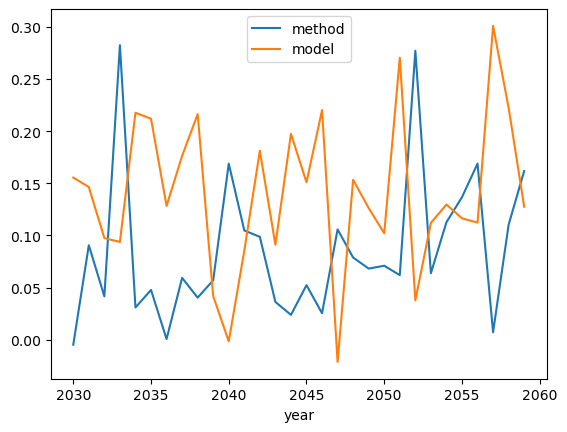

In [113]:
df_out.plot(x="year")